In [76]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as dr
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objs as go
from pandas import Series, DataFrame
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from pandas.plotting import lag_plot
from pandas_datareader import DataReader
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import tree, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import r2_score, precision_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from pmdarima.arima import auto_arima

In [2]:
indus = dr.get_data_yahoo('INDUSINDBK.NS', start = '2002-8-5',
                       end = '2022-1-1', interval = 'wk')

In [3]:
indus

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-08-04,16.750000,15.850000,16.200001,15.950000,107668.0,11.676104
2002-08-11,16.450001,15.600000,15.800000,16.299999,53814.0,11.932319
2002-08-18,16.750000,15.550000,16.250000,16.000000,143277.0,11.712705
2002-08-25,16.799999,15.850000,16.000000,15.900000,99178.0,11.639502
2002-09-01,16.250000,15.900000,16.000000,16.000000,71087.0,11.712705
...,...,...,...,...,...,...
2021-11-28,957.849976,875.700012,926.900024,951.150024,44128431.0,943.545105
2021-12-05,968.000000,914.000000,952.000000,944.750000,21543083.0,937.196289
2021-12-12,955.599976,880.250000,954.299988,883.000000,14918197.0,875.940002


#### LSTM

In [4]:
data = indus.filter(['Close'])
data.head()

,Close
Date,
2002-08-04,15.950000
2002-08-11,16.299999
2002-08-18,16.000000
2002-08-25,15.900000
2002-09-01,16.000000


In [5]:
ds = data.values

In [6]:
train_len = math.ceil(len(ds)*.7)
train_len

710

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ds)
scaled_data, scaled_data.shape

(array([[0.00117368],
        [0.00134848],
        [0.00119865],
        ...,
        [0.43421152],
        [0.42329881],
        [0.43678364]]),
 (1013, 1))

In [8]:
train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()
print(len(x_train))
print(len(y_train))

[array([0.00117368, 0.00134848, 0.00119865, 0.00114871, 0.00119865,
       0.00199775, 0.00094893, 0.00057435, 0.00037458, 0.00029966,
       0.00014983, 0.        , 0.00034961, 0.00037458, 0.00019978,
       0.00052441, 0.00094893, 0.00117368, 0.0014234 , 0.00147334,
       0.00132351, 0.00094893, 0.0009739 , 0.00184792, 0.00147334,
       0.00087402, 0.00122362, 0.00117368, 0.00154826, 0.00172306,
       0.00127357, 0.00122362, 0.00149831, 0.00114871, 0.00177301,
       0.00227244, 0.00227244, 0.00209764, 0.00237233, 0.0030216 ,
       0.00252216, 0.00254713, 0.00394556, 0.00312149, 0.00332126,
       0.0030216 , 0.00282183, 0.00372081, 0.00327132, 0.00451991,
       0.0050693 , 0.00626795, 0.00576851, 0.00591834, 0.00719191,
       0.00704208, 0.00599326, 0.00631789, 0.00486952, 0.00526907])]
[0.004669746783497857]

[array([0.00117368, 0.00134848, 0.00119865, 0.00114871, 0.00119865,
       0.00199775, 0.00094893, 0.00057435, 0.00037458, 0.00029966,
       0.00014983, 0.        , 0.0

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(650, 60, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.fit(x_train, y_train, batch_size=10, epochs=50)

Epoch 1/50
65/65 [==============================] - 8s 40ms/step - loss: 2.2716e-04
Epoch 2/50
65/65 [==============================] - 3s 39ms/step - loss: 1.5210e-04
Epoch 3/50
65/65 [==============================] - 2s 36ms/step - loss: 1.9680e-04
Epoch 4/50
65/65 [==============================] - 2s 35ms/step - loss: 1.6647e-04
Epoch 5/50
65/65 [==============================] - 2s 35ms/step - loss: 1.5451e-04
Epoch 6/50
65/65 [==============================] - 2s 35ms/step - loss: 1.1226e-04
Epoch 7/50
65/65 [==============================] - 2s 35ms/step - loss: 1.2621e-04
Epoch 8/50
65/65 [==============================] - 2s 35ms/step - loss: 1.0803e-04
Epoch 9/50
65/65 [==============================] - 2s 35ms/step - loss: 1.1526e-04
Epoch 10/50
65/65 [==============================] - 2s 35ms/step - loss: 1.5262e-04
Epoch 11/50
65/65 [==============================] - 2s 35ms/step - loss: 8.9334e-05
Epoch 12/50
65/65 [==============================] - 2s 35ms/step - loss: 

In [16]:
test_data = scaled_data[train_len-60:, :]
x_test = []
y_test = ds[train_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [17]:
x_test = np.array(x_test)

In [18]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [20]:
print(predictions[0:5], y_test[0:5])

[[927.6055]
 [920.7018]
 [917.142 ]
 [952.2393]
 [925.4812]] [[929.        ]
 [928.04998779]
 [961.29998779]
 [937.        ]
 [986.40002441]]


In [21]:
mse = np.mean(predictions-y_test)**2
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mse, rmse

(740.7178484264946, 27.216132135674506)

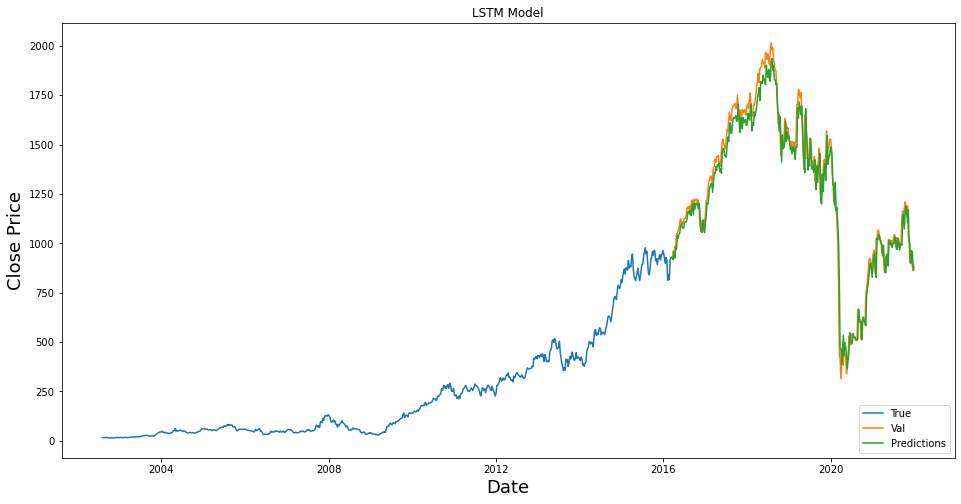

In [22]:
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

#### Prophet:

In [23]:
indusp = indus.reset_index()

In [24]:
df = indusp.filter(['Date', 'Close'])
df

,Date,Close
0,2002-08-04,15.950000
1,2002-08-11,16.299999
2,2002-08-18,16.000000
3,2002-08-25,15.900000
4,2002-09-01,16.000000
...,...,...
1008,2021-11-28,951.150024
1009,2021-12-05,944.750000
1010,2021-12-12,883.000000
1011,2021-12-19,861.150024


In [25]:
df.index[df['Close']<0]

Int64Index([], dtype='int64')

In [26]:
df['Close_shift'] = df['Close'] - df['Close'].shift(1)
y = df['Close_shift']

In [27]:
model1 = Prophet()

In [28]:
df.columns

Index(['Date', 'Close', 'Close_shift'], dtype='object')

In [29]:
df_prpht = df.rename(columns={'Date':'ds','Close_shift':'y'})

In [30]:
df_prpht.head()

,ds,Close,y
0,2002-08-04,15.950000,NaN
1,2002-08-11,16.299999,0.349999
2,2002-08-18,16.000000,-0.299999
3,2002-08-25,15.900000,-0.100000
4,2002-09-01,16.000000,0.100000


In [31]:
train_len1 = int(0.7*len(df))
train_len1

709

In [32]:
df_train = df_prpht[:train_len1]
df_test = df_prpht[train_len1:]
df_train, df_train.shape

(            ds       Close          y
 0   2002-08-04   15.950000        NaN
 1   2002-08-11   16.299999   0.349999
 2   2002-08-18   16.000000  -0.299999
 3   2002-08-25   15.900000  -0.100000
 4   2002-09-01   16.000000   0.100000
 ..         ...         ...        ...
 704 2016-01-31  911.849976 -16.950012
 705 2016-02-07  811.950012 -99.899963
 706 2016-02-14  841.500000  29.549988
 707 2016-02-21  816.349976 -25.150024
 708 2016-02-28  915.900024  99.550049
 
 [709 rows x 3 columns],
 (709, 3))

In [33]:
model1.fit(df_train)

06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:39 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
periods = len(df)-len(df_train)
periods

304

In [35]:
future_dates = model1.make_future_dataframe(periods=periods)

In [36]:
future_dates.shape

(1013, 1)

In [37]:
future_dates.head()

,ds
0,2002-08-04
1,2002-08-11
2,2002-08-18
3,2002-08-25
4,2002-09-01


In [38]:
prediction = model1.predict(future_dates)

In [39]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-08-04,-0.707337,-22.133905,14.980957,-0.707337,-0.707337,-3.006225,-3.006225,-3.006225,-3.006225,-3.006225,-3.006225,0.0,0.0,0.0,-3.713562
1,2002-08-11,-0.701744,-22.673580,12.968137,-0.701744,-0.701744,-4.491967,-4.491967,-4.491967,-4.491967,-4.491967,-4.491967,0.0,0.0,0.0,-5.193711
2,2002-08-18,-0.696151,-21.847431,12.704290,-0.696151,-0.696151,-3.781973,-3.781973,-3.781973,-3.781973,-3.781973,-3.781973,0.0,0.0,0.0,-4.478125
3,2002-08-25,-0.690559,-17.247482,16.732463,-0.690559,-0.690559,0.047964,0.047964,0.047964,0.047964,0.047964,0.047964,0.0,0.0,0.0,-0.642595
4,2002-09-01,-0.684966,-14.216851,20.562147,-0.684966,-0.684966,4.272924,4.272924,4.272924,4.272924,4.272924,4.272924,0.0,0.0,0.0,3.587958


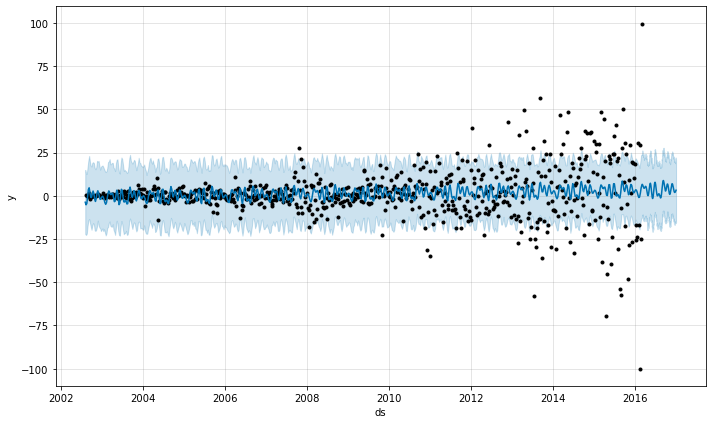

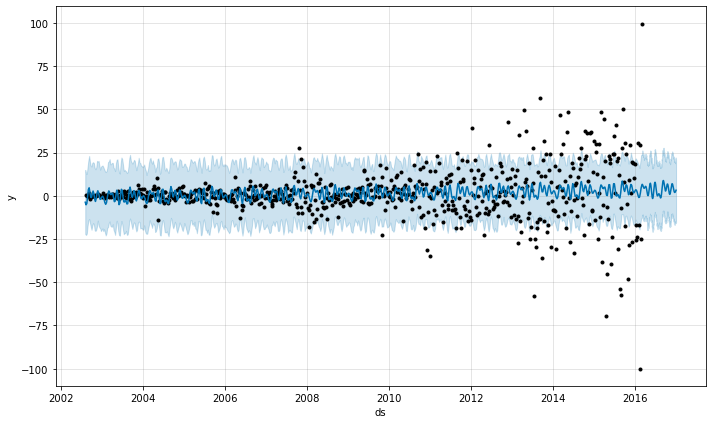

In [40]:
model1.plot(prediction)

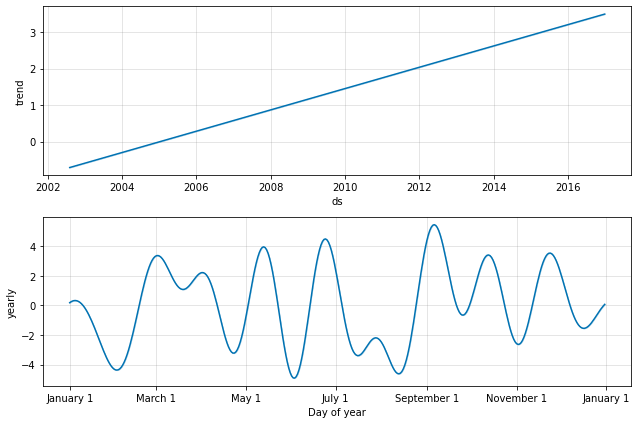

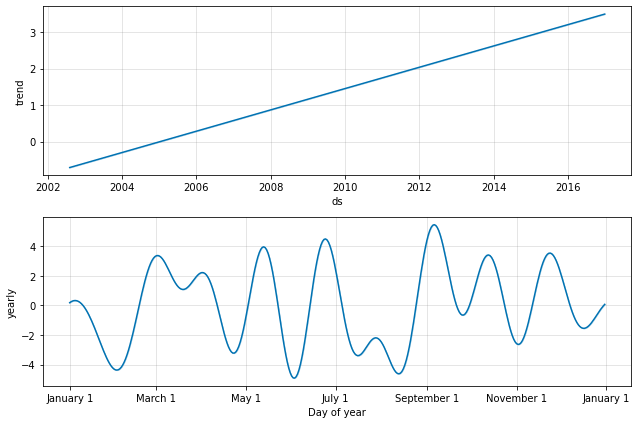

In [41]:
model1.plot_components(prediction)

In [42]:
df_train.shape, len(df)-len(df_train)

((709, 3), 304)

In [43]:
cv = cross_validation(model1, initial='709 days', period='3 days', horizon='304 days')

  0%|          | 0/1313 [00:00<?, ?it/s]

06:17:45 - cmdstanpy - INFO - Chain [1] start processing
06:17:46 - cmdstanpy - INFO - Chain [1] done processing
06:17:47 - cmdstanpy - INFO - Chain [1] start processing
06:17:47 - cmdstanpy - INFO - Chain [1] done processing
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
06:17:49 - cmdstanpy - INFO - Chain [1] done processing
06:17:50 - cmdstanpy - INFO - Chain [1] start processing
06:17:50 - cmdstanpy - INFO - Chain [1] done processing
06:17:52 - cmdstanpy - INFO - Chain [1] start processing
06:17:52 - cmdstanpy - INFO - Chain [1] done processing
06:17:53 - cmdstanpy - INFO - Chain [1] start processing
06:17:53 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1] done processing
06:17:58 - cmdstanpy - INFO - Chain [1] start processing
06:17:58 - cmdstanpy - INFO - Chain [1] done processing
06:18:00 - cmdstanpy - INFO - Chain [1] start processing
06:18:00 - cmdstanpy - INFO - Chain [1]

06:19:29 - cmdstanpy - INFO - Chain [1] done processing
06:19:30 - cmdstanpy - INFO - Chain [1] start processing
06:19:30 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1] done processing
06:19:35 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:37 - cmdstanpy - INFO - Chain [1] start processing
06:19:37 - cmdstanpy - INFO - Chain [1] done processing
06:19:38 - cmdstanpy - INFO - Chain [1] start processing
06:19:38 - cmdstanpy - INFO - Chain [1] done processing
06:19:40 - cmdstanpy - INFO - Chain [1] start processing
06:19:40 - cmdstanpy - INFO - Chain [1] done processing
06:19:41 - cmdstanpy - INFO - Chain [1] 

06:21:13 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:15 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:17 - cmdstanpy - INFO - Chain [1] start processing
06:21:17 - cmdstanpy - INFO - Chain [1] done processing
06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:20 - cmdstanpy - INFO - Chain [1] start processing
06:21:20 - cmdstanpy - INFO - Chain [1] done processing
06:21:21 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing
06:21:23 - cmdstanpy - INFO - Chain [1] start processing
06:21:23 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:25 - cmdstanpy - INFO - Chain [1] 

06:22:55 - cmdstanpy - INFO - Chain [1] done processing
06:22:57 - cmdstanpy - INFO - Chain [1] start processing
06:22:57 - cmdstanpy - INFO - Chain [1] done processing
06:22:58 - cmdstanpy - INFO - Chain [1] start processing
06:22:58 - cmdstanpy - INFO - Chain [1] done processing
06:22:59 - cmdstanpy - INFO - Chain [1] start processing
06:23:00 - cmdstanpy - INFO - Chain [1] done processing
06:23:01 - cmdstanpy - INFO - Chain [1] start processing
06:23:01 - cmdstanpy - INFO - Chain [1] done processing
06:23:02 - cmdstanpy - INFO - Chain [1] start processing
06:23:02 - cmdstanpy - INFO - Chain [1] done processing
06:23:04 - cmdstanpy - INFO - Chain [1] start processing
06:23:04 - cmdstanpy - INFO - Chain [1] done processing
06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:05 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1] done processing
06:23:08 - cmdstanpy - INFO - Chain [1] 

06:24:37 - cmdstanpy - INFO - Chain [1] done processing
06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1] done processing
06:24:41 - cmdstanpy - INFO - Chain [1] start processing
06:24:41 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1] done processing
06:24:49 - cmdstanpy - INFO - Chain [1] 

06:26:20 - cmdstanpy - INFO - Chain [1] done processing
06:26:21 - cmdstanpy - INFO - Chain [1] start processing
06:26:21 - cmdstanpy - INFO - Chain [1] done processing
06:26:23 - cmdstanpy - INFO - Chain [1] start processing
06:26:23 - cmdstanpy - INFO - Chain [1] done processing
06:26:24 - cmdstanpy - INFO - Chain [1] start processing
06:26:24 - cmdstanpy - INFO - Chain [1] done processing
06:26:25 - cmdstanpy - INFO - Chain [1] start processing
06:26:26 - cmdstanpy - INFO - Chain [1] done processing
06:26:27 - cmdstanpy - INFO - Chain [1] start processing
06:26:27 - cmdstanpy - INFO - Chain [1] done processing
06:26:29 - cmdstanpy - INFO - Chain [1] start processing
06:26:29 - cmdstanpy - INFO - Chain [1] done processing
06:26:30 - cmdstanpy - INFO - Chain [1] start processing
06:26:30 - cmdstanpy - INFO - Chain [1] done processing
06:26:32 - cmdstanpy - INFO - Chain [1] start processing
06:26:32 - cmdstanpy - INFO - Chain [1] done processing
06:26:33 - cmdstanpy - INFO - Chain [1] 

06:28:04 - cmdstanpy - INFO - Chain [1] done processing
06:28:06 - cmdstanpy - INFO - Chain [1] start processing
06:28:06 - cmdstanpy - INFO - Chain [1] done processing
06:28:07 - cmdstanpy - INFO - Chain [1] start processing
06:28:07 - cmdstanpy - INFO - Chain [1] done processing
06:28:09 - cmdstanpy - INFO - Chain [1] start processing
06:28:09 - cmdstanpy - INFO - Chain [1] done processing
06:28:10 - cmdstanpy - INFO - Chain [1] start processing
06:28:10 - cmdstanpy - INFO - Chain [1] done processing
06:28:12 - cmdstanpy - INFO - Chain [1] start processing
06:28:12 - cmdstanpy - INFO - Chain [1] done processing
06:28:13 - cmdstanpy - INFO - Chain [1] start processing
06:28:13 - cmdstanpy - INFO - Chain [1] done processing
06:28:15 - cmdstanpy - INFO - Chain [1] start processing
06:28:15 - cmdstanpy - INFO - Chain [1] done processing
06:28:16 - cmdstanpy - INFO - Chain [1] start processing
06:28:16 - cmdstanpy - INFO - Chain [1] done processing
06:28:17 - cmdstanpy - INFO - Chain [1] 

06:29:47 - cmdstanpy - INFO - Chain [1] done processing
06:29:48 - cmdstanpy - INFO - Chain [1] start processing
06:29:48 - cmdstanpy - INFO - Chain [1] done processing
06:29:49 - cmdstanpy - INFO - Chain [1] start processing
06:29:49 - cmdstanpy - INFO - Chain [1] done processing
06:29:51 - cmdstanpy - INFO - Chain [1] start processing
06:29:51 - cmdstanpy - INFO - Chain [1] done processing
06:29:52 - cmdstanpy - INFO - Chain [1] start processing
06:29:52 - cmdstanpy - INFO - Chain [1] done processing
06:29:53 - cmdstanpy - INFO - Chain [1] start processing
06:29:53 - cmdstanpy - INFO - Chain [1] done processing
06:29:55 - cmdstanpy - INFO - Chain [1] start processing
06:29:55 - cmdstanpy - INFO - Chain [1] done processing
06:29:56 - cmdstanpy - INFO - Chain [1] start processing
06:29:56 - cmdstanpy - INFO - Chain [1] done processing
06:29:58 - cmdstanpy - INFO - Chain [1] start processing
06:29:58 - cmdstanpy - INFO - Chain [1] done processing
06:29:59 - cmdstanpy - INFO - Chain [1] 

06:31:29 - cmdstanpy - INFO - Chain [1] done processing
06:31:30 - cmdstanpy - INFO - Chain [1] start processing
06:31:31 - cmdstanpy - INFO - Chain [1] done processing
06:31:32 - cmdstanpy - INFO - Chain [1] start processing
06:31:32 - cmdstanpy - INFO - Chain [1] done processing
06:31:34 - cmdstanpy - INFO - Chain [1] start processing
06:31:34 - cmdstanpy - INFO - Chain [1] done processing
06:31:35 - cmdstanpy - INFO - Chain [1] start processing
06:31:35 - cmdstanpy - INFO - Chain [1] done processing
06:31:37 - cmdstanpy - INFO - Chain [1] start processing
06:31:37 - cmdstanpy - INFO - Chain [1] done processing
06:31:38 - cmdstanpy - INFO - Chain [1] start processing
06:31:38 - cmdstanpy - INFO - Chain [1] done processing
06:31:39 - cmdstanpy - INFO - Chain [1] start processing
06:31:39 - cmdstanpy - INFO - Chain [1] done processing
06:31:41 - cmdstanpy - INFO - Chain [1] start processing
06:31:41 - cmdstanpy - INFO - Chain [1] done processing
06:31:42 - cmdstanpy - INFO - Chain [1] 

06:33:15 - cmdstanpy - INFO - Chain [1] done processing
06:33:16 - cmdstanpy - INFO - Chain [1] start processing
06:33:16 - cmdstanpy - INFO - Chain [1] done processing
06:33:18 - cmdstanpy - INFO - Chain [1] start processing
06:33:18 - cmdstanpy - INFO - Chain [1] done processing
06:33:19 - cmdstanpy - INFO - Chain [1] start processing
06:33:19 - cmdstanpy - INFO - Chain [1] done processing
06:33:21 - cmdstanpy - INFO - Chain [1] start processing
06:33:21 - cmdstanpy - INFO - Chain [1] done processing
06:33:22 - cmdstanpy - INFO - Chain [1] start processing
06:33:22 - cmdstanpy - INFO - Chain [1] done processing
06:33:23 - cmdstanpy - INFO - Chain [1] start processing
06:33:23 - cmdstanpy - INFO - Chain [1] done processing
06:33:25 - cmdstanpy - INFO - Chain [1] start processing
06:33:25 - cmdstanpy - INFO - Chain [1] done processing
06:33:26 - cmdstanpy - INFO - Chain [1] start processing
06:33:26 - cmdstanpy - INFO - Chain [1] done processing
06:33:28 - cmdstanpy - INFO - Chain [1] 

06:35:02 - cmdstanpy - INFO - Chain [1] done processing
06:35:03 - cmdstanpy - INFO - Chain [1] start processing
06:35:03 - cmdstanpy - INFO - Chain [1] done processing
06:35:05 - cmdstanpy - INFO - Chain [1] start processing
06:35:05 - cmdstanpy - INFO - Chain [1] done processing
06:35:06 - cmdstanpy - INFO - Chain [1] start processing
06:35:07 - cmdstanpy - INFO - Chain [1] done processing
06:35:08 - cmdstanpy - INFO - Chain [1] start processing
06:35:08 - cmdstanpy - INFO - Chain [1] done processing
06:35:09 - cmdstanpy - INFO - Chain [1] start processing
06:35:09 - cmdstanpy - INFO - Chain [1] done processing
06:35:11 - cmdstanpy - INFO - Chain [1] start processing
06:35:11 - cmdstanpy - INFO - Chain [1] done processing
06:35:12 - cmdstanpy - INFO - Chain [1] start processing
06:35:12 - cmdstanpy - INFO - Chain [1] done processing
06:35:13 - cmdstanpy - INFO - Chain [1] start processing
06:35:13 - cmdstanpy - INFO - Chain [1] done processing
06:35:15 - cmdstanpy - INFO - Chain [1] 

06:36:47 - cmdstanpy - INFO - Chain [1] done processing
06:36:48 - cmdstanpy - INFO - Chain [1] start processing
06:36:48 - cmdstanpy - INFO - Chain [1] done processing
06:36:50 - cmdstanpy - INFO - Chain [1] start processing
06:36:50 - cmdstanpy - INFO - Chain [1] done processing
06:36:50 - cmdstanpy - INFO - Chain [1] start processing
06:36:50 - cmdstanpy - INFO - Chain [1] done processing
06:36:52 - cmdstanpy - INFO - Chain [1] start processing
06:36:52 - cmdstanpy - INFO - Chain [1] done processing
06:36:53 - cmdstanpy - INFO - Chain [1] start processing
06:36:54 - cmdstanpy - INFO - Chain [1] done processing
06:36:55 - cmdstanpy - INFO - Chain [1] start processing
06:36:55 - cmdstanpy - INFO - Chain [1] done processing
06:36:56 - cmdstanpy - INFO - Chain [1] start processing
06:36:56 - cmdstanpy - INFO - Chain [1] done processing
06:36:57 - cmdstanpy - INFO - Chain [1] start processing
06:36:57 - cmdstanpy - INFO - Chain [1] done processing
06:36:59 - cmdstanpy - INFO - Chain [1] 

06:38:32 - cmdstanpy - INFO - Chain [1] done processing
06:38:34 - cmdstanpy - INFO - Chain [1] start processing
06:38:34 - cmdstanpy - INFO - Chain [1] done processing
06:38:35 - cmdstanpy - INFO - Chain [1] start processing
06:38:35 - cmdstanpy - INFO - Chain [1] done processing
06:38:36 - cmdstanpy - INFO - Chain [1] start processing
06:38:37 - cmdstanpy - INFO - Chain [1] done processing
06:38:38 - cmdstanpy - INFO - Chain [1] start processing
06:38:38 - cmdstanpy - INFO - Chain [1] done processing
06:38:40 - cmdstanpy - INFO - Chain [1] start processing
06:38:40 - cmdstanpy - INFO - Chain [1] done processing
06:38:41 - cmdstanpy - INFO - Chain [1] start processing
06:38:41 - cmdstanpy - INFO - Chain [1] done processing
06:38:43 - cmdstanpy - INFO - Chain [1] start processing
06:38:43 - cmdstanpy - INFO - Chain [1] done processing
06:38:44 - cmdstanpy - INFO - Chain [1] start processing
06:38:44 - cmdstanpy - INFO - Chain [1] done processing
06:38:45 - cmdstanpy - INFO - Chain [1] 

06:40:20 - cmdstanpy - INFO - Chain [1] done processing
06:40:22 - cmdstanpy - INFO - Chain [1] start processing
06:40:22 - cmdstanpy - INFO - Chain [1] done processing
06:40:23 - cmdstanpy - INFO - Chain [1] start processing
06:40:23 - cmdstanpy - INFO - Chain [1] done processing
06:40:24 - cmdstanpy - INFO - Chain [1] start processing
06:40:24 - cmdstanpy - INFO - Chain [1] done processing
06:40:25 - cmdstanpy - INFO - Chain [1] start processing
06:40:26 - cmdstanpy - INFO - Chain [1] done processing
06:40:27 - cmdstanpy - INFO - Chain [1] start processing
06:40:27 - cmdstanpy - INFO - Chain [1] done processing
06:40:29 - cmdstanpy - INFO - Chain [1] start processing
06:40:29 - cmdstanpy - INFO - Chain [1] done processing
06:40:30 - cmdstanpy - INFO - Chain [1] start processing
06:40:30 - cmdstanpy - INFO - Chain [1] done processing
06:40:31 - cmdstanpy - INFO - Chain [1] start processing
06:40:31 - cmdstanpy - INFO - Chain [1] done processing
06:40:33 - cmdstanpy - INFO - Chain [1] 

06:42:04 - cmdstanpy - INFO - Chain [1] done processing
06:42:06 - cmdstanpy - INFO - Chain [1] start processing
06:42:06 - cmdstanpy - INFO - Chain [1] done processing
06:42:07 - cmdstanpy - INFO - Chain [1] start processing
06:42:07 - cmdstanpy - INFO - Chain [1] done processing
06:42:09 - cmdstanpy - INFO - Chain [1] start processing
06:42:09 - cmdstanpy - INFO - Chain [1] done processing
06:42:10 - cmdstanpy - INFO - Chain [1] start processing
06:42:10 - cmdstanpy - INFO - Chain [1] done processing
06:42:12 - cmdstanpy - INFO - Chain [1] start processing
06:42:12 - cmdstanpy - INFO - Chain [1] done processing
06:42:13 - cmdstanpy - INFO - Chain [1] start processing
06:42:13 - cmdstanpy - INFO - Chain [1] done processing
06:42:14 - cmdstanpy - INFO - Chain [1] start processing
06:42:15 - cmdstanpy - INFO - Chain [1] done processing
06:42:16 - cmdstanpy - INFO - Chain [1] start processing
06:42:16 - cmdstanpy - INFO - Chain [1] done processing
06:42:18 - cmdstanpy - INFO - Chain [1] 

06:43:51 - cmdstanpy - INFO - Chain [1] done processing
06:43:53 - cmdstanpy - INFO - Chain [1] start processing
06:43:53 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:55 - cmdstanpy - INFO - Chain [1] done processing
06:43:56 - cmdstanpy - INFO - Chain [1] start processing
06:43:56 - cmdstanpy - INFO - Chain [1] done processing
06:43:57 - cmdstanpy - INFO - Chain [1] start processing
06:43:57 - cmdstanpy - INFO - Chain [1] done processing
06:43:59 - cmdstanpy - INFO - Chain [1] start processing
06:43:59 - cmdstanpy - INFO - Chain [1] done processing
06:44:00 - cmdstanpy - INFO - Chain [1] start processing
06:44:00 - cmdstanpy - INFO - Chain [1] done processing
06:44:02 - cmdstanpy - INFO - Chain [1] start processing
06:44:02 - cmdstanpy - INFO - Chain [1] done processing
06:44:03 - cmdstanpy - INFO - Chain [1] start processing
06:44:03 - cmdstanpy - INFO - Chain [1] done processing
06:44:05 - cmdstanpy - INFO - Chain [1] 

06:45:38 - cmdstanpy - INFO - Chain [1] done processing
06:45:40 - cmdstanpy - INFO - Chain [1] start processing
06:45:40 - cmdstanpy - INFO - Chain [1] done processing
06:45:41 - cmdstanpy - INFO - Chain [1] start processing
06:45:41 - cmdstanpy - INFO - Chain [1] done processing
06:45:43 - cmdstanpy - INFO - Chain [1] start processing
06:45:43 - cmdstanpy - INFO - Chain [1] done processing
06:45:44 - cmdstanpy - INFO - Chain [1] start processing
06:45:44 - cmdstanpy - INFO - Chain [1] done processing
06:45:45 - cmdstanpy - INFO - Chain [1] start processing
06:45:45 - cmdstanpy - INFO - Chain [1] done processing
06:45:47 - cmdstanpy - INFO - Chain [1] start processing
06:45:47 - cmdstanpy - INFO - Chain [1] done processing
06:45:48 - cmdstanpy - INFO - Chain [1] start processing
06:45:49 - cmdstanpy - INFO - Chain [1] done processing
06:45:50 - cmdstanpy - INFO - Chain [1] start processing
06:45:50 - cmdstanpy - INFO - Chain [1] done processing
06:45:51 - cmdstanpy - INFO - Chain [1] 

06:47:26 - cmdstanpy - INFO - Chain [1] done processing
06:47:27 - cmdstanpy - INFO - Chain [1] start processing
06:47:27 - cmdstanpy - INFO - Chain [1] done processing
06:47:29 - cmdstanpy - INFO - Chain [1] start processing
06:47:29 - cmdstanpy - INFO - Chain [1] done processing
06:47:30 - cmdstanpy - INFO - Chain [1] start processing
06:47:30 - cmdstanpy - INFO - Chain [1] done processing
06:47:32 - cmdstanpy - INFO - Chain [1] start processing
06:47:32 - cmdstanpy - INFO - Chain [1] done processing
06:47:33 - cmdstanpy - INFO - Chain [1] start processing
06:47:33 - cmdstanpy - INFO - Chain [1] done processing
06:47:35 - cmdstanpy - INFO - Chain [1] start processing
06:47:35 - cmdstanpy - INFO - Chain [1] done processing
06:47:36 - cmdstanpy - INFO - Chain [1] start processing
06:47:36 - cmdstanpy - INFO - Chain [1] done processing
06:47:38 - cmdstanpy - INFO - Chain [1] start processing
06:47:38 - cmdstanpy - INFO - Chain [1] done processing
06:47:39 - cmdstanpy - INFO - Chain [1] 

In [44]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-07-25,2.108294,-0.830869,5.124063,-1.700001,2004-07-20
1,2004-08-01,1.501747,-1.749099,4.361802,-3.150002,2004-07-20
2,2004-08-08,1.126269,-1.706002,4.215556,-3.949997,2004-07-20
3,2004-08-15,1.183451,-1.696961,4.077928,-2.250000,2004-07-20
4,2004-08-22,1.249711,-1.801271,4.132040,0.149998,2004-07-20


In [45]:
cv.shape

(57022, 6)

In [46]:
df_train_pm = performance_metrics(cv)

In [47]:
df_train_pm

,horizon,mse,rmse,mae,mdape,smape,coverage
0,31 days,172.518816,13.134642,8.687731,1.003640,1.601707,0.561621
1,32 days,172.277306,13.125445,8.677457,1.001828,1.599067,0.562168
2,33 days,172.687752,13.141071,8.689078,1.003147,1.600885,0.561888
3,34 days,172.915376,13.149729,8.701072,1.002064,1.601093,0.560711
4,35 days,172.673865,13.140543,8.690798,1.001424,1.598453,0.561291
...,...,...,...,...,...,...,...
269,300 days,235.901853,15.359097,10.312362,1.006068,1.627098,0.478219
270,301 days,238.349230,15.438563,10.346253,1.006288,1.627181,0.476834
271,302 days,237.249616,15.402909,10.321809,1.003367,1.625222,0.477309
272,303 days,238.097324,15.430403,10.342195,1.006484,1.628164,0.475640


In [48]:
MSE = sum(df_train_pm['mse'])/len(df_train_pm)
RMSE = sum(df_train_pm['rmse'])/len(df_train_pm)
MSE, RMSE

(202.12072720021717, 14.202872995760872)

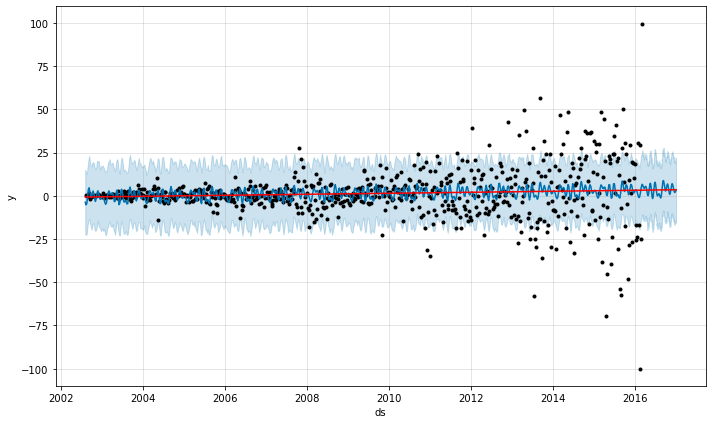

In [49]:
fig = model1.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model1, prediction)

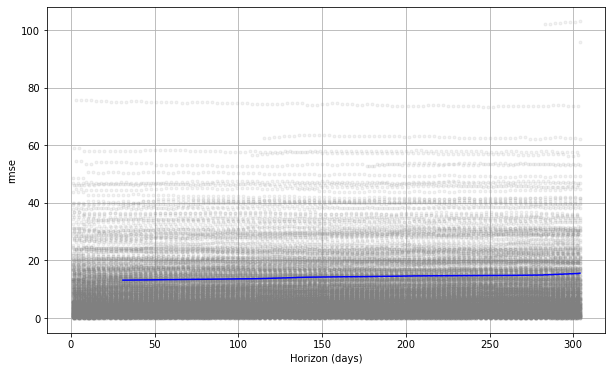

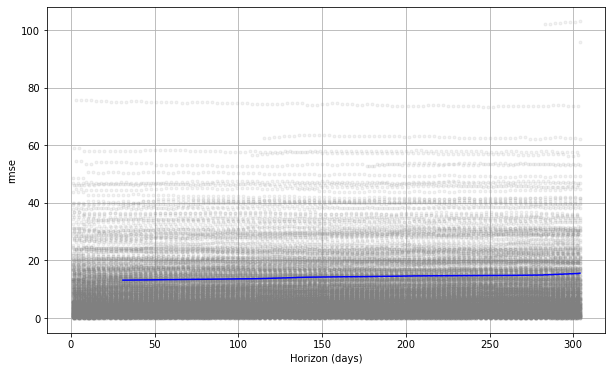

In [50]:
plot_cross_validation_metric(cv, metric='rmse')

In [51]:
from statsmodels.tsa.arima.model import ARIMA

In [52]:
model2 = pm.auto_arima(df_train['Close'], start_p=1, start_q=1, test='adf',
                      max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0,
                      D=0, trace=True, error_action='ignore', suppress_warnings=True,
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5797.610, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5793.662, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5795.612, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5795.612, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5797.129, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.551 seconds


In [53]:
model2 = ARIMA(df_train['Close'], order=(0,1,0))
model2_fit = model2.fit()

In [54]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  709
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2897.564
Date:                Fri, 04 Nov 2022   AIC                           5797.129
Time:                        06:49:20   BIC                           5801.691
Sample:                             0   HQIC                          5798.892
                                - 709                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       210.0499      4.808     43.690      0.000     200.627     219.473
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              2361.14
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              54.23   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
from pmdarima.arima import auto_arima

In [56]:
data = indus.sort_index(ascending=True, axis=0)

In [57]:
train = data[:709]
valid = data[709:]

In [58]:
training = train['Close']
validation = train['Close']

In [59]:
model_ar = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                     start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                     suppress_warnings=True)
model_ar.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6133.008, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5886.679, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6134.733, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5798.976, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5722.958, Time=1.93 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.03 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5723.721, Time=3.77 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.68 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5721.806, Time=0.76 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5887.078, 

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [60]:
forecast = model_ar.predict(n_periods=304)
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Prediction'])

In [64]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

562.4890457685116

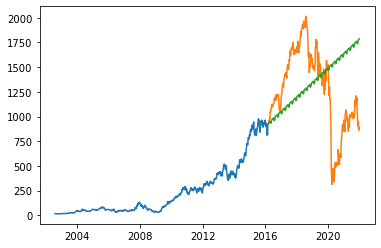

In [65]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

#### Moving average

In [66]:
data = indusp.sort_index(ascending=True, axis=0)

In [67]:
new_data = pd.DataFrame(index=range(0, len(indusp)), columns=['Date', 'Close'])

In [68]:
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
train = new_data[:709]
valid = new_data[709:]

In [69]:
train.shape, valid.shape

((709, 2), (304, 2))

In [70]:
preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train)-190+i:].sum() + sum(preds)
    b = a/190
    preds.append(b)

rmse = np.sqrt(np.mean(np.array(np.power((valid['Close'])-preds,2))))
rmse

680.3568771577702

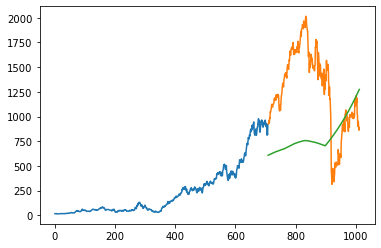

In [71]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

#### KNN Model

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [73]:
new_data = pd.DataFrame(indus, columns=['Open', 'High', 'Low', 'Close'])
train = new_data[:709]
valid = new_data[709:]

In [74]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [75]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

In [77]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model_knn = GridSearchCV(knn, params, cv = 5)

In [78]:
model_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]})

In [79]:
pred = model_knn.predict(x_valid)

In [80]:
rmse_knn = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(pred)),2)))
rmse_knn

733.2419951883776

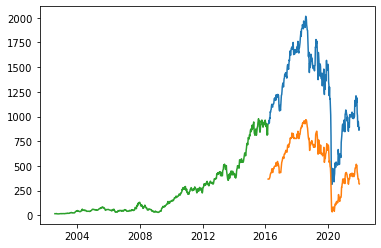

In [81]:
valid['Predictions'] = 0
valid['Predictions'] = pred
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])